In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torchvision import transforms

import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1

### Load Dataset

In [3]:
data_root = '../data/img_residential_original/'
all_data_dirs = os.listdir(data_root)
newlist = []
for names in all_data_dirs:
    if names.endswith(".png"):
        newlist.append(names)
all_data_dirs = [data_root + str(i) + '.png' for i in range(0,len(newlist))]

In [4]:
class Centeralize(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, image):
        tmp = image
        image = torch.sum(image, dim=0)/3
        h, w = image.shape
        half_h = half_w = int(self.output_size/2)
        grid_x = torch.FloatTensor([[i for i in range(0,w)] for j in range(0,h)])
        grid_y = torch.FloatTensor([[j for i in range(0,w)] for j in range(0,h)])
        img_reverse = (image<1).float()
        center_w = int(torch.sum(img_reverse*grid_x)/torch.sum(img_reverse))
        center_h = int(torch.sum(img_reverse*grid_y)/torch.sum(img_reverse))
        top = center_h - half_h
        left = center_w - half_w
        image = tmp[:, top: top + self.output_size,
                      left: left + self.output_size]
        return image
    
composed = transforms.Compose([
                                Centeralize(1000),
                                transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0)),
                                transforms.Grayscale(1),
                                transforms.Resize(112),
                                transforms.CenterCrop(56),
                              ])
def saveto(i):
    img = Image.open(all_data_dirs[i])
    img = np.array(img)/255.0
    img = np.transpose(img[:, :, :3], (2, 0, 1))
    img_tensor = torch.from_numpy(img.astype(np.float32))
    torch.save(composed(img_tensor), data_root + str(i) + '.pt')
for i in range(0,len(all_data_dirs)):
    try:
        saveto(i)
    except:
        pass

In [5]:
#Load Dataset
floor = FloorPlanDataset(root='../data/img_residential_original/',preprocess=True)
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])
data_variance = get_data_variance(train_set)

print(f"data shape: {floor[0].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

data shape: torch.Size([1, 56, 56]), dataset size: 2140, data variance: 0.0038599383551627398


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

### Load Best or Train

In [7]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 150
best_loss = 2

##### load best checkpoint

In [12]:
vqvae.load_state_dict(torch.load("../checkpoint/75-vqae-0.17452330009959569.pt"))
optimizer.load_state_dict(torch.load("../checkpoint/75-adam-0.17452330009959569.pt"))

with open("../checkpoint/75-vqae_train-0.17452330009959569.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../checkpoint/75-vqae_test-0.17452330009959569.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 75
end_epoch = 150
best_loss = 0.17452330009959569

##### train

In [8]:
for epoch in range(start_epoch, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)

    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:42<00:00,  2.68s/batch, loss=122]


Validation Loss: 4.67672173330717


100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.45batch/s, loss=100]


Validation Loss: 2.5139844662675235


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=73.3]


Validation Loss: 1.7276892973997882


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=61.5]


Validation Loss: 0.8773817971488025


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=21.2]


Validation Loss: 0.798384764484156


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=13]


Validation Loss: 0.546703356448735


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.23batch/s, loss=5.01]


Validation Loss: 0.5225008492157839


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=2.46]


Validation Loss: 0.47641312073324327


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.51batch/s, loss=3.21]


Validation Loss: 0.4749496317355432


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.50batch/s, loss=8.08]


Validation Loss: 0.7763615902339187


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.01batch/s, loss=4.33]


Validation Loss: 0.558342015631845


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=4.09]


Validation Loss: 0.6630905008761683


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=2.59]


Validation Loss: 0.41453088778201663


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.53batch/s, loss=1.82]


Validation Loss: 0.44450355244574147


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=1.06]


Validation Loss: 0.3533099522100431


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.977]


Validation Loss: 0.3473649782555126


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.15batch/s, loss=1.47]


Validation Loss: 0.5106478004812081


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.09batch/s, loss=0.718]


Validation Loss: 0.3145450698995145


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.58]


Validation Loss: 0.3295793622453636


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.532]


Validation Loss: 0.3381555147260149


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.546]


Validation Loss: 0.3090178409469462


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.44batch/s, loss=0.474]


Validation Loss: 0.2780130154618593


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.11batch/s, loss=0.607]


Validation Loss: 0.29841107519987586


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.542]


Validation Loss: 0.27446810107364833


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.58]


Validation Loss: 0.27644905197286157


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.38batch/s, loss=0.324]


Validation Loss: 0.2836966291766301


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.93batch/s, loss=0.606]


Validation Loss: 0.27481774303400625


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.336]


Validation Loss: 0.25409077261095847


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.386]


Validation Loss: 0.2662333016083619


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.424]


Validation Loss: 0.3106427861151294


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.41batch/s, loss=0.391]


Validation Loss: 0.2406537332267405


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.29batch/s, loss=0.392]


Validation Loss: 0.26852646052280316


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.99batch/s, loss=5.37]


Validation Loss: 3.287262675918151


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.12batch/s, loss=0.546]


Validation Loss: 0.4883096819726106


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.423]


Validation Loss: 0.3614308187894732


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.38batch/s, loss=0.396]


Validation Loss: 0.33075696285639966


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.15batch/s, loss=0.85]


Validation Loss: 0.29490816704580713


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.00batch/s, loss=0.302]


Validation Loss: 0.26066100931613245


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.445]


Validation Loss: 0.25139936999739887


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.32batch/s, loss=0.285]


Validation Loss: 0.26037485354414613


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.295]


Validation Loss: 0.22959268872982988


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.99batch/s, loss=0.241]


Validation Loss: 0.2267618179321289


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.233]


Validation Loss: 0.22635726393940292


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.217]


Validation Loss: 2.50136908415322


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.286]


Validation Loss: 0.22095175769841557


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.241]


Validation Loss: 0.22521254281017267


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.80batch/s, loss=0.323]


Validation Loss: 0.22464757544972072


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.06batch/s, loss=0.327]


Validation Loss: 0.21852592218702085


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.20batch/s, loss=0.855]


Validation Loss: 0.5254459381103516


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.09batch/s, loss=0.24]


Validation Loss: 0.23455348861551728


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.184]


Validation Loss: 0.21139676994252427


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.61batch/s, loss=0.183]


Validation Loss: 0.2114592578923591


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.207]


Validation Loss: 0.2870775739723277


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.03batch/s, loss=0.203]


Validation Loss: 0.40569916841025666


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.25batch/s, loss=0.182]


Validation Loss: 0.2316692477074739


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37batch/s, loss=0.412]


Validation Loss: 0.21892294482650043


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s, loss=0.187]


Validation Loss: 0.2872526311428747


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=0.24]


Validation Loss: 0.3120946349384629


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.27batch/s, loss=0.216]


Validation Loss: 0.22653728556410174


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.77batch/s, loss=0.147]


Validation Loss: 0.19932775408308084


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.21batch/s, loss=0.52]


Validation Loss: 0.23948379766161196


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.197]


Validation Loss: 0.21143781358950606


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.201]


Validation Loss: 0.21635822046582942


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.151]


Validation Loss: 0.19382065924528602


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.193]


Validation Loss: 0.24206271127005605


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.30batch/s, loss=0.783]


Validation Loss: 0.2624999875220183


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=5.96]


Validation Loss: 0.6194932884145006


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s, loss=0.255]


Validation Loss: 0.56495978453449


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.41batch/s, loss=0.305]


Validation Loss: 1.180167474479319


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.90batch/s, loss=0.141]


Validation Loss: 0.4618906395457615


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.05batch/s, loss=0.158]


Validation Loss: 0.5153437284665687


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.21batch/s, loss=0.23]


Validation Loss: 0.3876202663528585


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.161]


Validation Loss: 2.250973710389895


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.02batch/s, loss=0.176]


Validation Loss: 0.2967782778160594


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=0.161]


Validation Loss: 0.20057888565776505


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.92batch/s, loss=0.182]


Validation Loss: 0.17452330009959569


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.05batch/s, loss=0.184]


Validation Loss: 0.17773817187157748


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.73batch/s, loss=5.93]


Validation Loss: 7.821684364960572


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.24batch/s, loss=0.299]


Validation Loss: 2.388611624174029


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.321]


Validation Loss: 0.7176524367287894


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.13batch/s, loss=0.382]


Validation Loss: 1.0478826505001462


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.67batch/s, loss=0.342]


Validation Loss: 1.0509785447165232


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.24batch/s, loss=0.328]


Validation Loss: 0.9717853581793954


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.12batch/s, loss=0.22]


Validation Loss: 0.8816178223797094


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.85batch/s, loss=0.304]


Validation Loss: 1.0211739584664317


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.278]


Validation Loss: 0.7782430559675271


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.53batch/s, loss=0.253]


Validation Loss: 0.7700790690484448


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.32batch/s, loss=0.651]


Validation Loss: 0.6678430788984923


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.44batch/s, loss=0.252]


Validation Loss: 0.9458201042959623


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.86batch/s, loss=0.174]


Validation Loss: 0.9255844187513691


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.74batch/s, loss=0.181]


Validation Loss: 0.8580974329297788


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.09batch/s, loss=0.563]


Validation Loss: 0.7475045819148839


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.20batch/s, loss=0.153]


Validation Loss: 1.206217828198014


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.15batch/s, loss=1.35]


Validation Loss: 0.8652400792202103


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.09batch/s, loss=0.208]


Validation Loss: 0.9755768107476636


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.32batch/s, loss=0.303]


Validation Loss: 0.9611542603679907


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.95batch/s, loss=0.209]


Validation Loss: 1.279397982303227


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.61batch/s, loss=0.365]


Validation Loss: 1.3343078042859229


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.46batch/s, loss=0.183]


Validation Loss: 1.519430641816041


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.57batch/s, loss=0.178]


Validation Loss: 1.193285291440019


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.142]


Validation Loss: 1.3604573757849008


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.92batch/s, loss=0.916]


Validation Loss: 1.0045844104802497


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.95batch/s, loss=0.151]


Validation Loss: 1.1752071202358354


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.57batch/s, loss=0.173]


Validation Loss: 1.1666315025258287


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.06batch/s, loss=0.223]


Validation Loss: 1.0590587509012668


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.98batch/s, loss=0.53]


Validation Loss: 0.9228212944815093


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.53batch/s, loss=0.137]


Validation Loss: 1.1570493751597182


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.169]


Validation Loss: 1.345698347715574


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=0.148]


Validation Loss: 0.965297092901212


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.91batch/s, loss=0.18]


Validation Loss: 1.174764294490636


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.70batch/s, loss=0.216]


Validation Loss: 1.25963243145809


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.80batch/s, loss=0.173]


Validation Loss: 0.872199406133634


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.83batch/s, loss=0.149]


Validation Loss: 1.0082421347359631


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.93batch/s, loss=0.175]


Validation Loss: 0.8449462462808485


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.186]


Validation Loss: 1.1808837819322249


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.17]


Validation Loss: 1.1532730744263837


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.46batch/s, loss=0.246]


Validation Loss: 0.8195848910608023


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.77batch/s, loss=0.154]


Validation Loss: 1.0102369718462507


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.85batch/s, loss=0.717]


Validation Loss: 0.9936405074930637


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.96batch/s, loss=0.158]


Validation Loss: 0.9795618859406944


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.13batch/s, loss=0.167]


Validation Loss: 0.8972018945997007


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.27batch/s, loss=0.138]


Validation Loss: 0.9361000417548919


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.79batch/s, loss=0.13]


Validation Loss: 0.8836936237656068


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.95batch/s, loss=0.201]


Validation Loss: 1.0124824024806514


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.135]


Validation Loss: 0.9183612003504673


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.82batch/s, loss=0.121]


Validation Loss: 0.8271322517751534


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.54batch/s, loss=0.16]


Validation Loss: 0.7980737418771904


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.20batch/s, loss=0.173]


Validation Loss: 0.8559049089378286


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.69batch/s, loss=0.135]


Validation Loss: 0.7409627326181001


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.67batch/s, loss=0.144]


Validation Loss: 0.8738853240681586


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.87batch/s, loss=0.732]


Validation Loss: 0.7604566912784755


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.64batch/s, loss=0.124]


Validation Loss: 0.7591215115841303


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.94batch/s, loss=0.165]


Validation Loss: 0.9665903465770116


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.94batch/s, loss=0.127]


Validation Loss: 0.8148570907450168


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16batch/s, loss=0.155]


Validation Loss: 0.7262619945490472


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.13batch/s, loss=0.171]


Validation Loss: 0.8443140047732915


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.98batch/s, loss=0.154]


Validation Loss: 0.9147445821316442


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.93batch/s, loss=0.116]


Validation Loss: 0.7861566989221305


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.18batch/s, loss=0.225]


Validation Loss: 0.74907402680299


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.13batch/s, loss=0.149]


Validation Loss: 0.710423014988409


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.07batch/s, loss=0.166]


Validation Loss: 0.9855006209043699


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.00batch/s, loss=0.111]


Validation Loss: 0.8459938619738427


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.18batch/s, loss=0.132]


Validation Loss: 0.8259216023382739


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.18batch/s, loss=0.249]


Validation Loss: 0.7696508603675343


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.31batch/s, loss=0.106]


Validation Loss: 0.875239256386445


100%|██████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.04batch/s, loss=0.0898]


Validation Loss: 0.7933661558917751


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.24batch/s, loss=0.116]


Validation Loss: 0.8504667906003578


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.04batch/s, loss=0.115]


Validation Loss: 0.8278776507511317


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.03batch/s, loss=0.18]


Validation Loss: 0.6977982209107586


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.10batch/s, loss=0.104]


Validation Loss: 0.8165455755786362


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.179]


Validation Loss: 0.8169722512503651


### Visualization

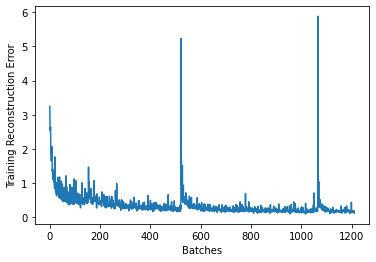

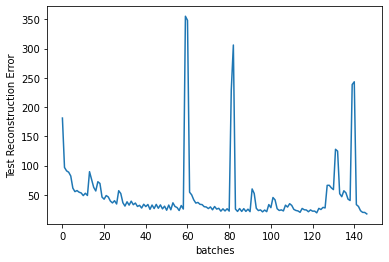

In [13]:
plt.plot(train_res_recon_error[5:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[5:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

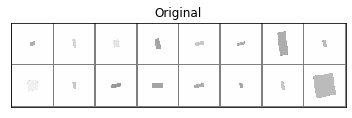

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


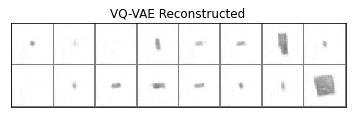

In [14]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)
def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()